# Brain Tumor Detection using CNN

# Importing packages

In [2]:
import numpy as np
import torch #it is an open source deep learning library 
from torch.utils.data import Dataset, DataLoader, ConcatDataset #provids tools for creating datasets and dataloaders
import glob #used to find all the pathnames matching a specified pattern according to the rules used by the unix shell
import matplotlib.pyplot as plt #for data visualization
from sklearn.metrics import confusion_matrix, accuracy_score 
import random #implements pseudo-random number
import cv2 #used for image processing tasks.
import sys #provides access to some variables used or maintained by the Python interpreter and functions that interact with the interpreter.

# Reading Images

In [52]:
# to read the images
#This loop iterates over each image file in the specified directory using glob.iglob
#(path). For each image file (i), it reads the image using cv2.imread(i), resizes it 
#to (120, 120) using cv2.resize(), and then rearranges the color channels from BGR to 
#RGB using cv2.split() and cv2.merge().
#The processed image (img) is then appended to the tumor list.
#Please note that the code assumes that the images are in the BGR format, and the color 
#channels are rearranged to RGB. Additionally, make sure that the directory specified in 
#path contains the desired images and that OpenCV and the glob module are correctly 
#imported in your script.

tumor = []
healthy = []
for f in glob.iglob("./data/brain_tumor_dataset/yes/*.jpg"):
    img = cv2.imread(f)
    img = cv2.resize(img,(128,128))
    b, g, r = cv2.split(img)
    img = cv2.merge([r,g,b])
    tumor.append(img)

for f in glob.iglob("./data/brain_tumor_dataset/no/*.jpg"):
    img = cv2.imread(f)
    img = cv2.resize(img,(128,128)) 
    b, g, r = cv2.split(img)
    img = cv2.merge([r,g,b])
    healthy.append(img)

In [4]:
healthy = np.array(healthy)
tumor = np.array(tumor)
All = np.concatenate((healthy, tumor))

In [5]:
healthy.shape

(86, 128, 128, 3)

In [6]:
tumor.shape

(86, 128, 128, 3)

In [7]:
np.random.choice(10, 5, replace=False)

array([4, 7, 6, 5, 0])

# Visualization of Brain MRI Scans

In [8]:
def plot_random(healthy, tumor, num=5):
    healthy_imgs = healthy[np.random.choice(healthy.shape[0], num, replace=False)]
    tumor_imgs = tumor[np.random.choice(tumor.shape[0], num, replace=False)]
    
    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('healthy')
        plt.imshow(healthy_imgs[i])
        
    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('tumor')
        plt.imshow(tumor_imgs[i])

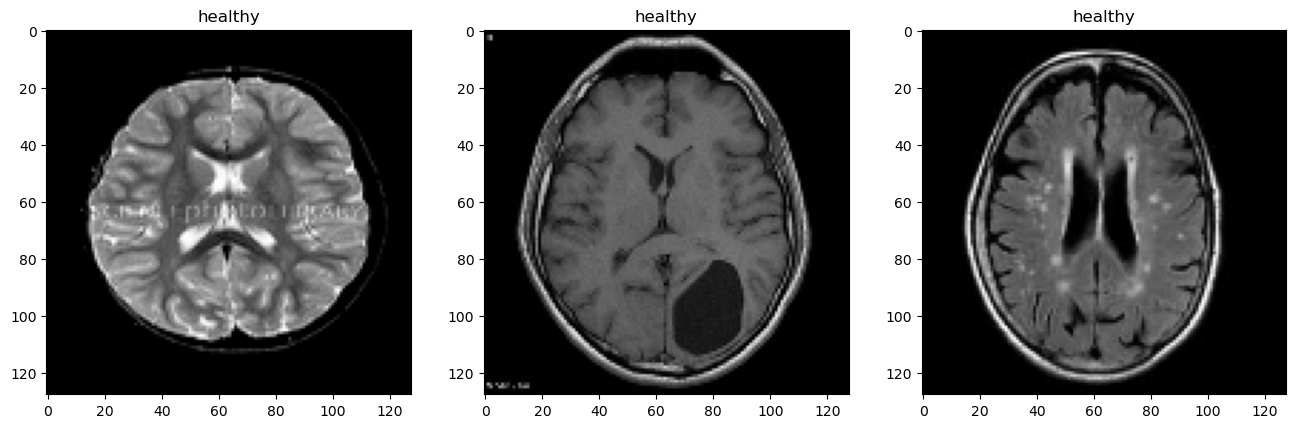

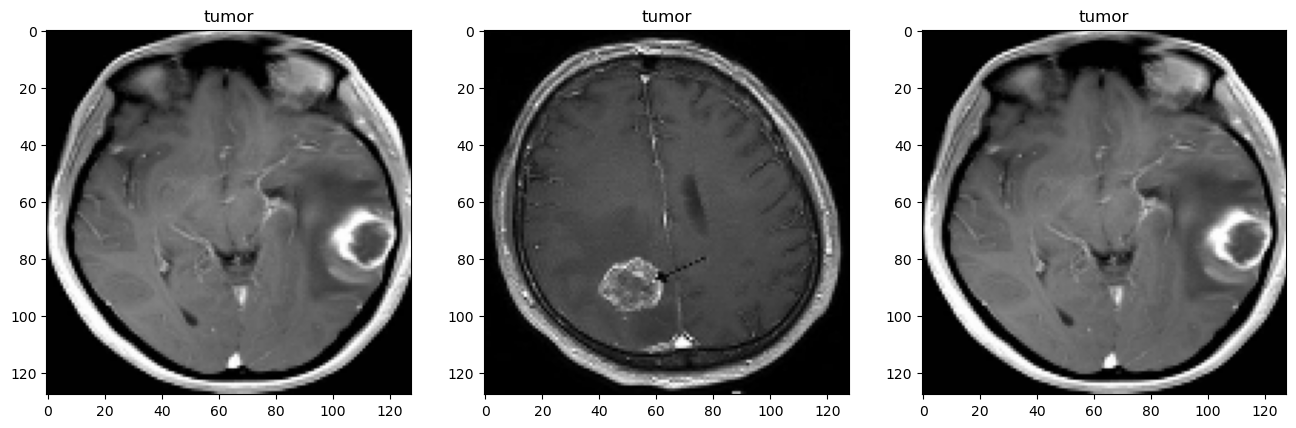

In [9]:
plot_random(healthy, tumor, num=3)


# Creating MRI dataset class

In [10]:
class MRI(Dataset):
    def __init__(self):
        
        tumor = []
        healthy = []
        # cv2 - It reads in BGR format by default
        for f in glob.iglob("./data/brain_tumor_dataset/yes/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) # I can add this later in the boot-camp for more adventure
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1])) # otherwise the shape will be (h,w,#channels)
            tumor.append(img)

        for f in glob.iglob("./data/brain_tumor_dataset/no/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) 
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1]))
            healthy.append(img)

        # our images
        tumor = np.array(tumor,dtype=np.float32)
        healthy = np.array(healthy,dtype=np.float32)
        
        # our labels
        tumor_label = np.ones(tumor.shape[0], dtype=np.float32)
        healthy_label = np.zeros(healthy.shape[0], dtype=np.float32)
        
        # Concatenates
        self.images = np.concatenate((tumor, healthy), axis=0)
        self.labels = np.concatenate((tumor_label, healthy_label))
        
    def __len__(self):
        return self.images.shape[0]
    
    def __getitem__(self, index):
        
        sample = {'image': self.images[index], 'label':self.labels[index]}
        
        return sample
    
    def normalize(self):
        self.images = self.images/255.0

In [11]:
mri_dataset = MRI()
mri_dataset.normalize()


# Creating  a Dataloader

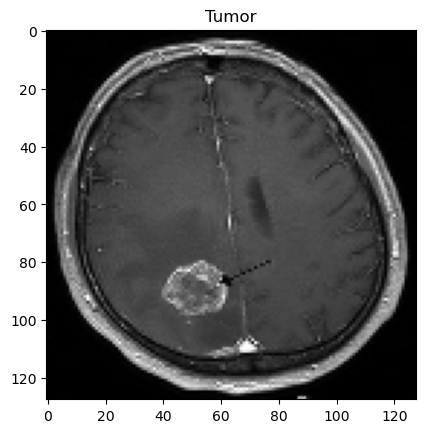

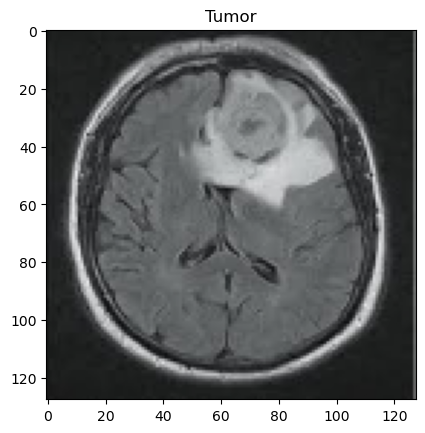

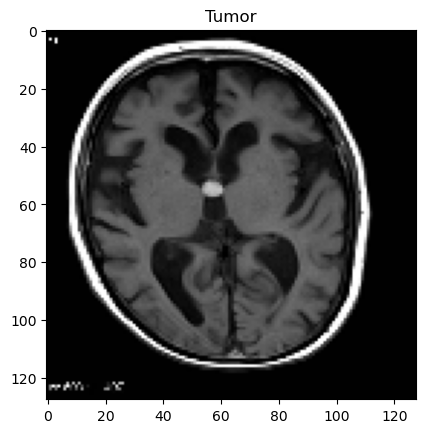

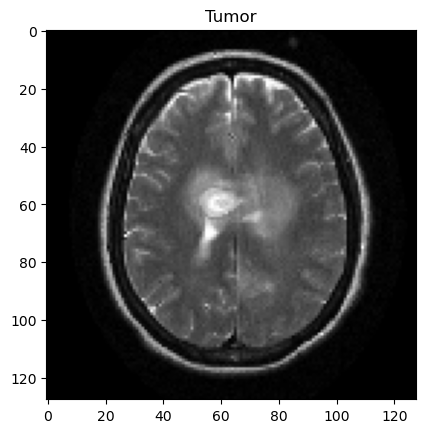

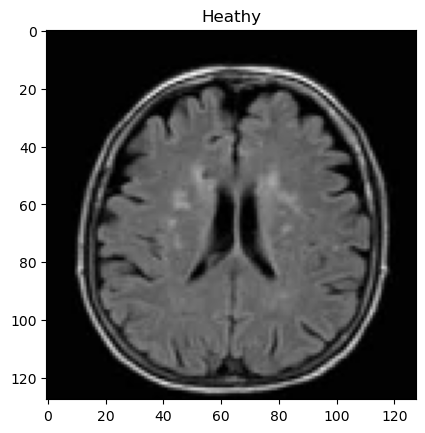

In [53]:
# One way of iterating
names={0:'Heathy', 1:'Tumor'}
dataloader = DataLoader(mri_dataset, shuffle=True)
for i, sample in enumerate(dataloader):
    img = sample['image'].squeeze()
    img = img.reshape((img.shape[1], img.shape[2], img.shape[0]))
    plt.title(names[sample['label'].item()])
    plt.imshow(img)
    plt.show()
    if i == 4:
        break


# Creating CNN Model

In [13]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.cnn_model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5),
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5))
        
        self.fc_model = nn.Sequential(
        nn.Linear(in_features=256, out_features=120),
        nn.Tanh(),
        nn.Linear(in_features=120, out_features=84),
        nn.Tanh(),
        nn.Linear(in_features=84, out_features=1))
        
    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc_model(x)
        x = F.sigmoid(x)
        
        return x
            

In [14]:
# device will be 'cuda' if a GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# creating a CPU tensor
cpu_tensor = torch.rand(10).to(device)
# moving same tensor to GPU
gpu_tensor = cpu_tensor.to(device)

print(cpu_tensor, cpu_tensor.dtype, type(cpu_tensor), cpu_tensor.type())
print(gpu_tensor, gpu_tensor.dtype, type(gpu_tensor), gpu_tensor.type())

print(cpu_tensor*gpu_tensor)

tensor([0.5592, 0.6755, 0.6506, 0.6393, 0.5216, 0.2247, 0.9785, 0.9580, 0.9383,
        0.1546]) torch.float32 <class 'torch.Tensor'> torch.FloatTensor
tensor([0.5592, 0.6755, 0.6506, 0.6393, 0.5216, 0.2247, 0.9785, 0.9580, 0.9383,
        0.1546]) torch.float32 <class 'torch.Tensor'> torch.FloatTensor
tensor([0.3127, 0.4563, 0.4233, 0.4087, 0.2721, 0.0505, 0.9575, 0.9178, 0.8803,
        0.0239])


In [15]:
# mri_dataset = MRI()
# mri_dataset.normalize()
# device = torch.device('cuda:0')
# model = CNN().to(device)
mri_dataset = MRI()
mri_dataset.normalize()

# Use CPU instead of GPU
device = torch.device('cpu')

# Create the model on the CPU
model = CNN().to(device)


In [16]:
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)

In [17]:
model.eval()
outputs = []
y_true = []
with torch.no_grad():
    for D in dataloader:
        image = D['image'].to(device)
        label = D['label'].to(device)

        y_hat = model(image)

        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())
    

In [18]:
outputs = np.concatenate( outputs, axis=0 ).squeeze()
y_true = np.concatenate( y_true, axis=0 ).squeeze()

In [19]:
def threshold(scores,threshold=0.50, minimum=0, maximum = 1.0):
    x = np.array(list(scores))
    x[x >= threshold] = maximum
    x[x < threshold] = minimum
    return x


In [20]:
accuracy_score(y_true, threshold(outputs))

0.5

In [21]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Assuming y_true and outputs are available
# y_true = ...  # Your true labels
# outputs = ...  # Continuous scores or probabilities

# Applying threshold function to get binary predictions
binary_predictions = threshold(outputs)

# Computing confusion matrix
cm = confusion_matrix(y_true, binary_predictions)

# Extracting individual metrics
accuracy = accuracy_score(y_true, binary_predictions)
precision = precision_score(y_true, binary_predictions)
recall = recall_score(y_true, binary_predictions)
f1 = f1_score(y_true, binary_predictions)

# Displaying the confusion matrix
print("Confusion Matrix:")
print(cm)

# Displaying individual metrics
print("\nMetrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Confusion Matrix:
[[86  0]
 [86  0]]

Metrics:
Accuracy: 0.5000
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


/Users/Nayyar/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Text(0, 0.5, 'Tumor'), Text(0, 1.5, 'Healthy')]

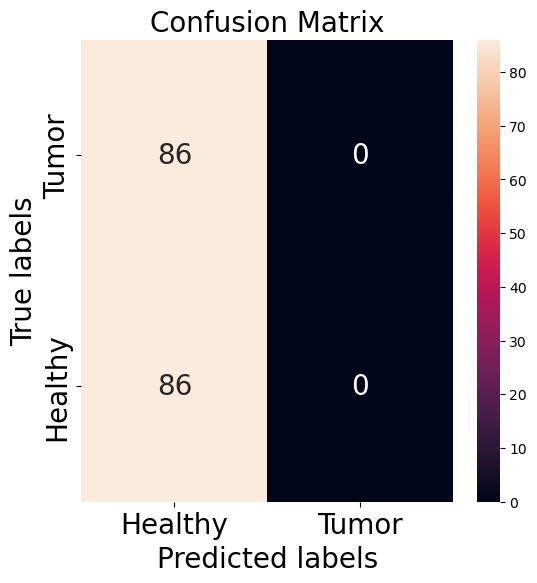

In [22]:
# a better confusion matrix
import seaborn as sns

plt.figure(figsize=(6,6))
cm = confusion_matrix(y_true, threshold(outputs))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, annot_kws={"size": 20})

# labels, title and ticks
ax.set_xlabel('Predicted labels', fontsize=20)
ax.set_ylabel('True labels', fontsize=20) 
ax.set_title('Confusion Matrix', fontsize=20)
ax.xaxis.set_ticklabels(['Healthy','Tumor'], fontsize=20)
ax.yaxis.set_ticklabels(['Tumor','Healthy'], fontsize=20)

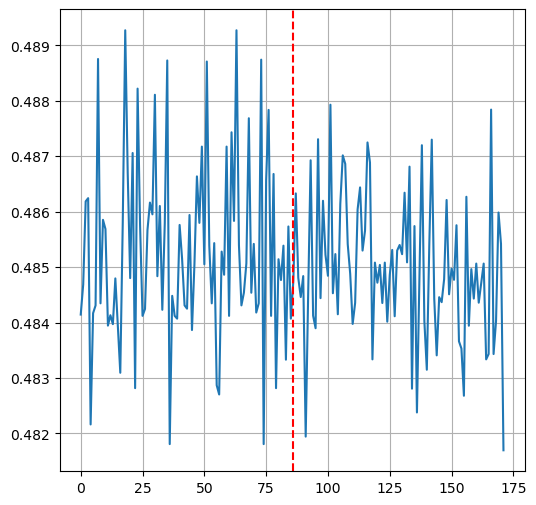

In [23]:
plt.figure(figsize=(6,6))
plt.plot(outputs)
plt.axvline(x=len(tumor), color='r', linestyle='--')
plt.grid()

In [24]:
eta = 0.0001
EPOCH = 400
optimizer = torch.optim.Adam(model.parameters(), lr=eta)
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=True)
model.train()


/Users/Nayyar/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [25]:
for epoch in range(1, EPOCH):
    losses = []
    for D in dataloader:
        optimizer.zero_grad()
        data = D['image'].to(device)
        label = D['label'].to(device)
        y_hat = model(data)
        # define loss function
        error = nn.BCELoss() 
        loss = torch.sum(error(y_hat.squeeze(), label))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    if (epoch+1) % 10 == 0:
        print('Train Epoch: {}\tLoss: {:.6f}'.format(epoch+1, np.mean(losses)))

Train Epoch: 10	Loss: 0.679862
Train Epoch: 20	Loss: 0.651880
Train Epoch: 30	Loss: 0.582923
Train Epoch: 40	Loss: 0.539436
Train Epoch: 50	Loss: 0.506973
Train Epoch: 60	Loss: 0.485516
Train Epoch: 70	Loss: 0.438176
Train Epoch: 80	Loss: 0.395069
Train Epoch: 90	Loss: 0.365050
Train Epoch: 100	Loss: 0.343381
Train Epoch: 110	Loss: 0.320485
Train Epoch: 120	Loss: 0.298806
Train Epoch: 130	Loss: 0.290863
Train Epoch: 140	Loss: 0.259879
Train Epoch: 150	Loss: 0.217400
Train Epoch: 160	Loss: 0.200725
Train Epoch: 170	Loss: 0.160792
Train Epoch: 180	Loss: 0.147410
Train Epoch: 190	Loss: 0.124097
Train Epoch: 200	Loss: 0.095520
Train Epoch: 210	Loss: 0.079661
Train Epoch: 220	Loss: 0.068981
Train Epoch: 230	Loss: 0.059751
Train Epoch: 240	Loss: 0.053139
Train Epoch: 250	Loss: 0.042564
Train Epoch: 260	Loss: 0.033095
Train Epoch: 270	Loss: 0.029378
Train Epoch: 280	Loss: 0.020757
Train Epoch: 290	Loss: 0.019223
Train Epoch: 300	Loss: 0.015935
Train Epoch: 310	Loss: 0.012426
Train Epoch: 320	

# Evaluate a Smart Model

In [26]:
model.eval()
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)
outputs=[]
y_true = []
with torch.no_grad():
    for D in dataloader:
        image =  D['image'].to(device)
        label = D['label'].to(device)
        
        y_hat = model(image)
        
        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())
        
outputs = np.concatenate( outputs, axis=0 )
y_true = np.concatenate( y_true, axis=0 )

In [27]:
accuracy_score(y_true, threshold(outputs))


1.0

[Text(0, 0.5, 'Tumor'), Text(0, 1.5, 'Healthy')]

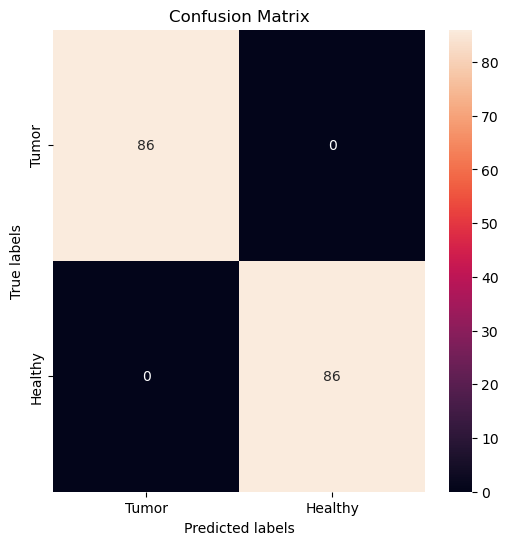

In [28]:
cm = confusion_matrix(y_true, threshold(outputs))
plt.figure(figsize=(6,6))

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Tumor','Healthy'])
ax.yaxis.set_ticklabels(['Tumor','Healthy'])

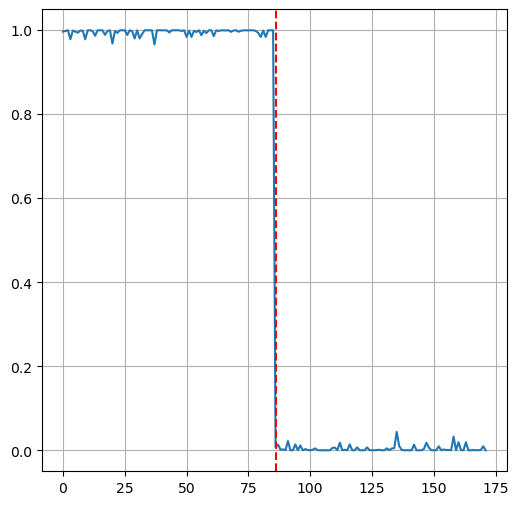

In [29]:
plt.figure(figsize=(6,6))
plt.plot(outputs)
plt.axvline(x=len(tumor), color='r', linestyle='--')
plt.grid()

# Visualising the Feature Maps of the Convolutional Filters

In [30]:
model

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [31]:
no_of_layers = 0
conv_layers = []

In [32]:
model_children = list(model.children())
model_children

[Sequential(
   (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
   (1): Tanh()
   (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
   (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
   (4): Tanh()
   (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
 ),
 Sequential(
   (0): Linear(in_features=256, out_features=120, bias=True)
   (1): Tanh()
   (2): Linear(in_features=120, out_features=84, bias=True)
   (3): Tanh()
   (4): Linear(in_features=84, out_features=1, bias=True)
 )]

In [33]:
for child in model_children:
    if type(child) == nn.Sequential:
        for layer in child.children():
            if type(layer) == nn.Conv2d:
                no_of_layers += 1
                conv_layers.append(layer)

In [34]:
conv_layers

[Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1)),
 Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))]

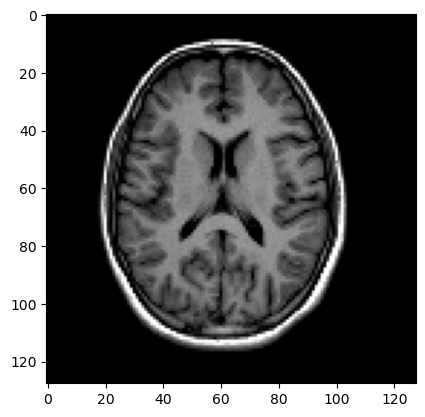

In [35]:
img = mri_dataset[100]['image']
plt.imshow(img.reshape(128,128,3))

In [36]:
img = torch.from_numpy(img).to(device)

In [37]:

img.shape

torch.Size([3, 128, 128])

In [38]:
img = img.unsqueeze(0)
img.shape

torch.Size([1, 3, 128, 128])

In [39]:
results = [conv_layers[0](img)]
for i in range(1, len(conv_layers)):
    results.append(conv_layers[i](results[-1]))
outputs = results

Layer  1


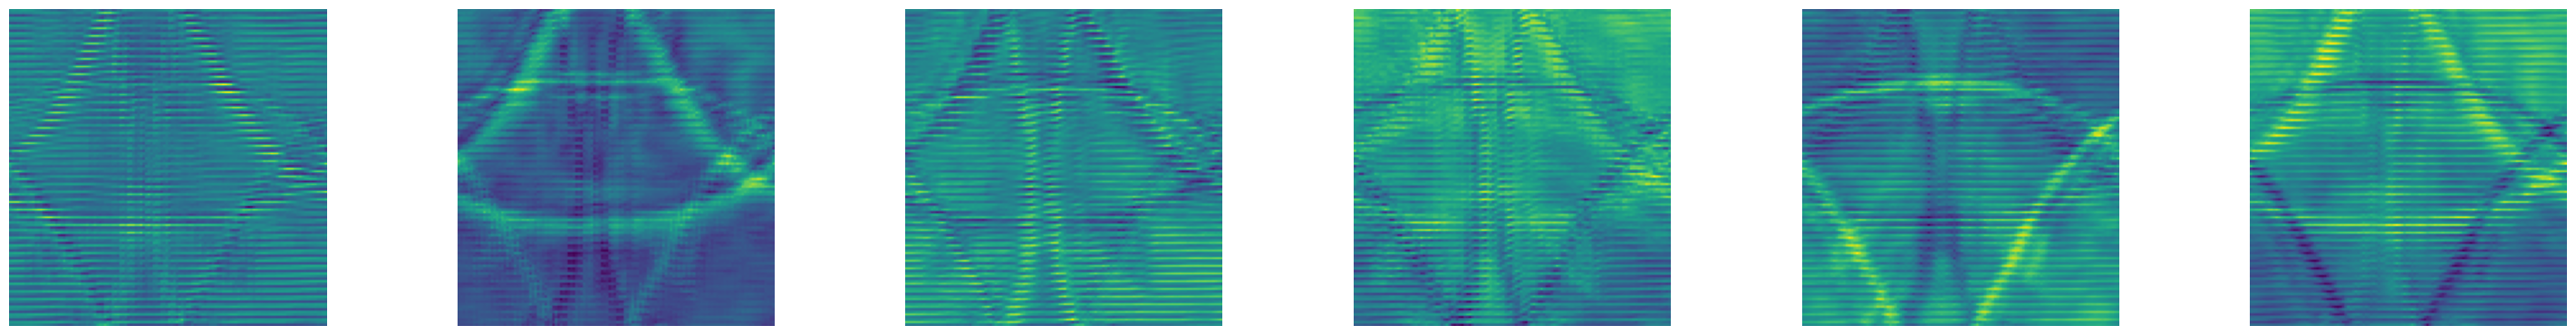

Layer  2


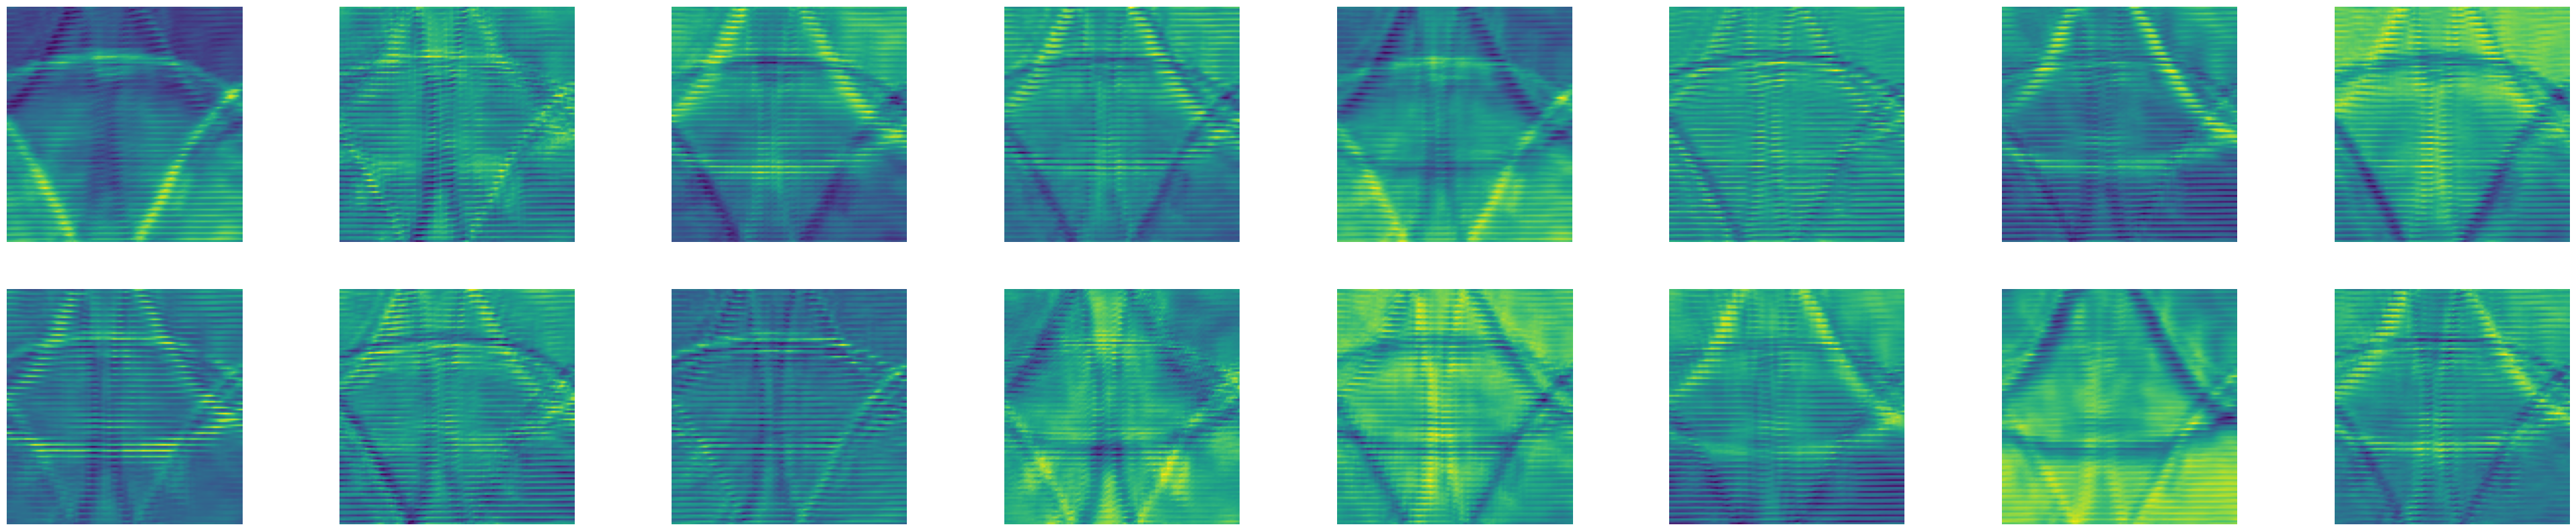

In [40]:
for num_layer in range(len(outputs)):
    plt.figure(figsize=(50, 10))
    layer_viz = outputs[num_layer].squeeze()
    print("Layer ",num_layer+1)
    for i, f in enumerate(layer_viz):
        plt.subplot(2, 8, i + 1)
        plt.imshow(f.detach().cpu().numpy())
        plt.axis("off")
    plt.show()
    plt.close()

# Checking Over Fitting 

In [41]:
# Import train/test split function from sklearn
from sklearn.model_selection import train_test_split

In [42]:
class MRI(Dataset):
    
    def __init__(self):
        
        # Variables to hold the Training data and Validation data
        self.X_train, self.y_train, self.X_val, self.y_val = None, None, None, None
        
        # A variable to determine if we are interested in retrieving the training OR the validation data
        self.mode = 'train'
        
        tumor = []
        healthy = []
        # cv2 - It reads in BGR format by default
        for f in glob.iglob("./data/brain_tumor_dataset/yes/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) # I can add this later in the boot-camp for more adventure
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1])) # otherwise the shape will be (h,w,#channels)
            tumor.append(img)

        for f in glob.iglob("./data/brain_tumor_dataset/no/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) 
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1]))
            healthy.append(img)

        # our images
        tumor = np.array(tumor,dtype=np.float32)
        healthy = np.array(healthy,dtype=np.float32)
        
        # our labels
        tumor_label = np.ones(tumor.shape[0], dtype=np.float32)
        healthy_label = np.zeros(healthy.shape[0], dtype=np.float32)
        
        # Concatenates
        self.images = np.concatenate((tumor, healthy), axis=0)
        self.labels = np.concatenate((tumor_label, healthy_label))
    
    # Define a function that would separate the data into Training and Validation sets
    def train_val_split(self):
        self.X_train, self.X_val, self.y_train, self.y_val = \
        train_test_split(self.images, self.labels, test_size=0.20, random_state=42)
        
    def __len__(self):
        # Use self.mode to deetrmine whether train or val data is of interest
        if self.mode == 'train':
            return self.X_train.shape[0]
        elif self.mode == 'val':
            return self.X_val.shape[0]
    
    def __getitem__(self, idx):
        # Use self.mode to deetrmine whether train or val data is of interest
        if self.mode== 'train':
            sample = {'image': self.X_train[idx], 'label': self.y_train[idx]}
        
        elif self.mode== 'val':
            sample = {'image': self.X_val[idx], 'label': self.y_val[idx]}
        
        return sample
    
    def normalize(self):
        self.images = self.images/255.0

In [43]:
mri_dataset = MRI()
mri_dataset.normalize()
mri_dataset.train_val_split()

In [44]:
train_dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)

In [45]:
device = torch.device("cpu")
model = CNN().to(device)

In [46]:
eta=0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=eta)

In [47]:
# keep track of epoch losses
epoch_train_loss = []
epoch_val_loss = []

In [48]:
for epoch in range(1,600):
    train_losses = []
    # train for the current epoch
    model.train()
    mri_dataset.mode = 'train'
    for D in train_dataloader:
        # Train the model
        optimizer.zero_grad()
        data = D['image'].to(device)
        label = D['label'].to(device)
        
        y_hat = model(data)
        error = nn.BCELoss()
        loss = torch.sum(error(y_hat.squeeze(), label))
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    epoch_train_loss.append(np.mean(train_losses))
    
    # validate for the current epoch
    val_losses = []
    model.eval()
    
    mri_dataset.mode = 'val'
    
    with torch.no_grad():
        for D in val_dataloader:            
            data = D['image'].to(device)
            label = D['label'].to(device)
            y_hat = model(data)
            error = nn.BCELoss()
            loss = torch.sum(error(y_hat.squeeze(), label))
            val_losses.append(loss.item())
    
    epoch_val_loss.append(np.mean(val_losses))
    
    if (epoch+1) % 10 == 0:
        print('Train Epoch: {}\tTrain Loss: {:.6f}\tVal Loss: {:.6f}'.format(epoch+1, np.mean(train_losses),np.mean(val_losses)))
    

Train Epoch: 10	Train Loss: 0.678744	Val Loss: 0.670008
Train Epoch: 20	Train Loss: 0.634449	Val Loss: 0.648713
Train Epoch: 30	Train Loss: 0.561280	Val Loss: 0.632332
Train Epoch: 40	Train Loss: 0.526981	Val Loss: 0.614681
Train Epoch: 50	Train Loss: 0.521032	Val Loss: 0.622355
Train Epoch: 60	Train Loss: 0.521539	Val Loss: 0.607275
Train Epoch: 70	Train Loss: 0.482021	Val Loss: 0.576213
Train Epoch: 80	Train Loss: 0.470121	Val Loss: 0.594320
Train Epoch: 90	Train Loss: 0.473620	Val Loss: 0.558699
Train Epoch: 100	Train Loss: 0.453293	Val Loss: 0.541520
Train Epoch: 110	Train Loss: 0.445985	Val Loss: 0.518765
Train Epoch: 120	Train Loss: 0.398914	Val Loss: 0.519507
Train Epoch: 130	Train Loss: 0.429712	Val Loss: 0.501914
Train Epoch: 140	Train Loss: 0.395457	Val Loss: 0.475498
Train Epoch: 150	Train Loss: 0.338962	Val Loss: 0.454352
Train Epoch: 160	Train Loss: 0.375705	Val Loss: 0.418743
Train Epoch: 170	Train Loss: 0.356463	Val Loss: 0.411112
Train Epoch: 180	Train Loss: 0.287203	Va

Text(0, 0.5, 'Loss')

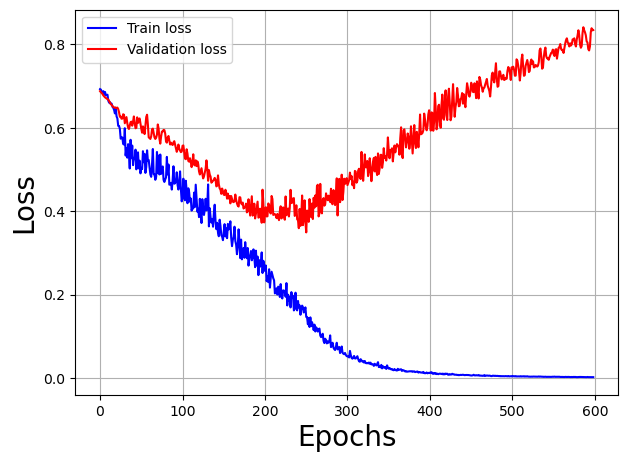

In [49]:
plt.figure(figsize=(7,5))
plt.plot(epoch_train_loss, c='b', label='Train loss')
plt.plot(epoch_val_loss, c='r', label = 'Validation loss')
plt.legend()
plt.grid()
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)

In [50]:
# from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# # Assuming y_true and outputs are available
# # y_true = ...  # Your true labels
# # outputs = ...  # Continuous scores or probabilities

# # Applying threshold function to get binary predictions
# binary_predictions = threshold(outputs)

# # Computing confusion matrix
# cm = confusion_matrix(y_true, binary_predictions)

# # Extracting individual metrics
# accuracy = accuracy_score(y_true, binary_predictions)
# precision = precision_score(y_true, binary_predictions)
# recall = recall_score(y_true, binary_predictions)
# f1 = f1_score(y_true, binary_predictions)

# # Displaying the confusion matrix
# print("Confusion Matrix:")
# print(cm)

# # Displaying individual metrics
# print("\nMetrics:")
# print(f"Accuracy: {accuracy:.4f}")
# print(f"Precision: {precision:.4f}")
# print(f"Recall: {recall:.4f}")
# print(f"F1 Score: {f1:.4f}")


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [ ]:
pip install torchvision


In [ ]:
pip install pillow


In [51]:
import torch
from PIL import Image
import torchvision.transforms as transforms

# Assuming you have already defined and loaded your model
# model = ...

# Define the device (use 'cuda' if available, otherwise use 'cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load and preprocess the image
image_path = "3 no.jpg"
image = Image.open(image_path)
preprocess = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),  # Converts to a PyTorch tensor
    # Add other preprocessing steps as needed
])
input_tensor = preprocess(image).unsqueeze(0)  # Add batch dimension

# Move the tensor to the appropriate device (CPU or GPU)
input_tensor = input_tensor.to(device)

# Ensure the model is in evaluation mode
model.eval()

# Perform inference
with torch.no_grad():
    output = model(input_tensor)

# Apply a threshold if necessary
threshold = 0.5  # Adjust based on your task and model characteristics
prediction = 1 if output.item() >= threshold else 0

# Print the prediction
print("Predicted class:", "Tumor" if prediction == 1 else "Healthy")


Predicted class: Healthy


In [ ]:
# Save the model weights after training
torch.save(model.state_dict(), 'model_weights.pth')
